### Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
from collections import Counter
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.sankey import Sankey

### Load the combined annotation file

In [2]:
# processed_annotation = "../annotated_files/processed/combined_annotations.csv"
analysis_annotation = "../annotated_files/analysis/combined_annotations.csv"

In [4]:
analysis_annotation_df = pd.read_csv(analysis_annotation)
print(f'shape of analysis annotation: {analysis_annotation_df.shape}')
analysis_annotation_df.sample(2)

shape of analysis annotation: (228788, 31)


,text-topic,text-topic-exp,text-entity-name,text-entity-gender,text-entity-sentiment,text-entity-sentiment-exp,text-generic-frame,text-generic-frame-exp,text-issue-frame,text-issue-frame-exp,...,date_publish,description,language,maintext,source_domain,url,political_leaning,text-generic-frame,img-generic-frame-len,text-generic-frame-len
60977,Royal Coronation,The article discusses the coronation of King C...,Sir Karl Jenkins,male,positive,Sir Karl Jenkins is portrayed in a positive li...,"['Public Opinion', 'Political', 'Cultural iden...",The article discusses public opinions and atti...,Humorous Cultural Phenomenon,The article discusses a viral joke and conspir...,...,2023-05-11 06:00:02,"Last weekend, social media users watching the ...",en,"A shaggy-haired, mustachioed and bespectacled ...",www.foxnews.com,https://www.foxnews.com/entertainment/welsh-co...,right,"['public_op', 'political', 'culture']",1,3
213241,Weather,The article discusses a winter storm affecting...,Massachusetts coast,NaN,Neutral,The article is reporting a weather event happe...,"['Security and defense', 'Health and safety']",The article discusses a winter storm that pose...,Natural Disaster Threat,The article focuses on a winter storm bringing...,...,2024-02-13 12:15:00,A winter storm is bringing wind and waves to t...,en,A winter storm is bringing wind and waves to t...,www.cbsnews.com,https://www.cbsnews.com/boston/video/massachus...,left_lean,"['security', 'health']",1,2


In [5]:
# rename ' short-text-generic-frame' column to 'short-text-generic-frame'
analysis_annotation_df.rename(columns={' text-generic-frame': 'short-text-generic-frame'}, inplace=True)
analysis_annotation_df.sample(2)

,text-topic,text-topic-exp,text-entity-name,text-entity-gender,text-entity-sentiment,text-entity-sentiment-exp,text-generic-frame,text-generic-frame-exp,text-issue-frame,text-issue-frame-exp,...,date_publish,description,language,maintext,source_domain,url,political_leaning,short-text-generic-frame,img-generic-frame-len,text-generic-frame-len
124942,Transportation Infrastructure,The article discusses the expansion of the Sec...,Second Avenue subway,NaN,positive,The article describes the Second Avenue subway...,"['Economic', 'Quality of life']",The article discusses the financial benefits (...,Progress and Opportunity,The article focuses on the expansion of the Se...,...,2023-07-07 10:57:00,The MTA says phase 2 of the project will be a ...,en,Second Avenue subway expanding into Harlem The...,www.cbsnews.com,https://www.cbsnews.com/newyork/video/second-a...,left_lean,"['economic', 'quality_life']",1,2
163301,Litigation,The article discusses a legal case brought aga...,JPMorgan Chase,NaN,Neutral,The article reports on a settlement agreement ...,"['Crime and punishment', 'legality, constituti...",The article discusses a legal case brought aga...,Moral Accountability,The article focuses on JPMorgan Chase reaching...,...,2023-06-12 13:38:19,JPMorgan Chase announced Monday that the insti...,en,JPMorgan Chase announced Monday that the insti...,dailycaller.com,https://dailycaller.com/2023/06/12/jpmorgan-se...,right,"['crime', 'legality', 'morality']",1,3


In [6]:
analysis_annotation_df['gpt-topic'].value_counts()

gpt-topic
Politics        38803
Crime           35237
Business        17495
Legal           16749
Health          13937
                ...  
Jobs                1
Philanthropy        1
Medical             1
Diversity           1
Shopping            1
Name: count, Length: 201, dtype: int64

In [7]:
# remove 'no-topic' value from gpt-topic column
analysis_annotation_df = analysis_annotation_df[analysis_annotation_df['gpt-topic'] != 'no_topic']
print(f'shape of analysis annotation after removing no-topic: {analysis_annotation_df.shape}') 

shape of analysis annotation after removing no-topic: (225249, 31)


In [8]:
analysis_annotation_df.columns

Index(['text-topic', 'text-topic-exp', 'text-entity-name',
       'text-entity-gender', 'text-entity-sentiment',
       'text-entity-sentiment-exp', 'text-generic-frame',
       'text-generic-frame-exp', 'text-issue-frame', 'text-issue-frame-exp',
       'uuid', 'title', 'img-generic-frame', 'img-frame-exp',
       'img-entity-name', 'img-entity-gender', 'img-entity-sentiment',
       'img-entity-sentiment-exp', 'image-url', 'gpt-topic', 'authors',
       'date_publish', 'description', 'language', 'maintext', 'source_domain',
       'url', 'political_leaning', 'short-text-generic-frame',
       'img-generic-frame-len', 'text-generic-frame-len'],
      dtype='object')

### List of political leanings

In [9]:
left_hosts = ['alternet.org', 'editor.cnn.com', 'democracynow.org', 'dailybeast.com', 'huffpost.com', 'theintercept.com','jacobin.com', 'motherjones.com', 'newyorker.com', 'slate.com',   'msnbc.com', 'vox.com']
left_lean_hosts = ['abcnews.com','apnews.com', 'theatlantic.com', 'bloomberg.com', 'cbsnews.com', 'insider.com', 'nbcnews.com', 'thenytimes.com', 'npr.com', 'politico.com', 'propublica.org', 'time.com', 'washingtonpost.com', 'yahoonews.com','usatoday.com', 'theguardian.com']
center_hosts = ['axios.com', 'bbc.com', 'forbes.com', 'newsweek.com', 'reuters.com', 'realclearpolitics.com', 'thehill.com']
right_lean_hosts = ['thedispatch.com', 'theepochtimes.com', 'foxbusiness.com', 'ijr.com', 'nypost.com', 'thepostmillennial.com', 'washingtonexaminer.com', 'washingtontimes.com']
right_hosts = ['theamericanconservative.com', 'theamericanspectator.com', 'breitbart.com', 'dailycaller.com', 'dailywire.com', 'dailymail.com', 'foxnews.com', 'newsmax.com', 'oann.com', 'thefederalist.com']

### Add political leanings to the combined annotation file
Look for part of name in the list of political leanings. E.g. 'nypost.com' should also be matched with 'today.nypost.com' (made up example)

In [10]:
left_hosts = ['alternet.org', 'editor.cnn.com', 'democracynow.org', 'dailybeast.com', 'huffpost.com', 'theintercept.com','jacobin.com', 'motherjones.com', 'newyorker.com', 'slate.com',   'msnbc.com', 'vox.com']
left_lean_hosts = ['abcnews.com','apnews.com', 'theatlantic.com', 'bloomberg.com', 'cbsnews.com', 'insider.com', 'nbcnews.com', 'thenytimes.com', 'npr.com', 'politico.com', 'propublica.org', 'time.com', 'washingtonpost.com', 'yahoonews.com','usatoday.com', 'theguardian.com']
center_hosts = ['axios.com', 'bbc.com', 'forbes.com', 'newsweek.com', 'reuters.com', 'realclearpolitics.com', 'thehill.com']
right_lean_hosts = ['thedispatch.com', 'theepochtimes.com', 'foxbusiness.com', 'ijr.com', 'nypost.com', 'thepostmillennial.com', 'washingtonexaminer.com', 'washingtontimes.com']
right_hosts = ['theamericanconservative.com', 'theamericanspectator.com', 'breitbart.com', 'dailycaller.com', 'dailywire.com', 'dailymail.com', 'foxnews.com', 'newsmax.com', 'oann.com', 'thefederalist.com']

# add political leaning to df if df column 'source_domain' has names in following lists
def get_political_leaning(domain):
    if any(host in domain for host in left_hosts):
        return 'left'
    elif any(host in domain for host in left_lean_hosts):
        return 'left'
    elif any(host in domain for host in center_hosts):
        return 'center'
    elif any(host in domain for host in right_lean_hosts):
        return 'right'
    elif any(host in domain for host in right_hosts):
        return 'right'
    else:
        return 'unknown'

In [11]:
#Add political leanings to the combined annotation file
#Look for part of name in the list of political leanings. E.g. 'nypost.com' should also be matched with 'today.nypost.com' (made up example)

analysis_annotation_df['political_leaning'] = analysis_annotation_df['source_domain'].apply(get_political_leaning)
print(f'shape of analysis annotation with political leaning: {analysis_annotation_df.shape}')

shape of analysis annotation with political leaning: (225249, 31)


In [12]:
# remove column where political leaning is unknown
analysis_annotation_df = analysis_annotation_df[analysis_annotation_df['political_leaning'] != 'unknown']
print(f'shape of analysis annotation with political leaning (excluding unknown): {analysis_annotation_df.shape}')

shape of analysis annotation with political leaning (excluding unknown): (225249, 31)


In [13]:
analysis_annotation_df.columns

Index(['text-topic', 'text-topic-exp', 'text-entity-name',
       'text-entity-gender', 'text-entity-sentiment',
       'text-entity-sentiment-exp', 'text-generic-frame',
       'text-generic-frame-exp', 'text-issue-frame', 'text-issue-frame-exp',
       'uuid', 'title', 'img-generic-frame', 'img-frame-exp',
       'img-entity-name', 'img-entity-gender', 'img-entity-sentiment',
       'img-entity-sentiment-exp', 'image-url', 'gpt-topic', 'authors',
       'date_publish', 'description', 'language', 'maintext', 'source_domain',
       'url', 'political_leaning', 'short-text-generic-frame',
       'img-generic-frame-len', 'text-generic-frame-len'],
      dtype='object')

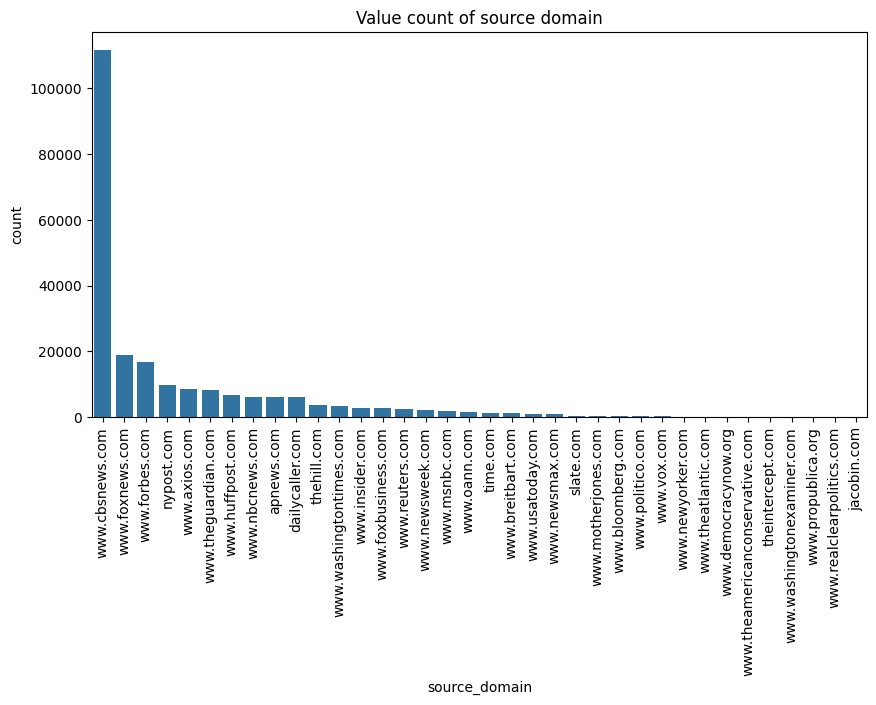

In [14]:
### Plot value count of source domain
plt.figure(figsize=(10, 5))

sns.countplot(x='source_domain', data=analysis_annotation_df, order=analysis_annotation_df['source_domain'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Value count of source domain')
plt.show()


In [15]:
print(f'Value count of source domain: {analysis_annotation_df.shape}')
analysis_annotation_df['source_domain'].value_counts()

Value count of source domain: (225249, 31)


source_domain
www.cbsnews.com                    111533
www.foxnews.com                     18767
www.forbes.com                      16873
nypost.com                           9678
www.axios.com                        8502
www.theguardian.com                  8246
www.huffpost.com                     6776
www.nbcnews.com                      6195
apnews.com                           6009
dailycaller.com                      5981
thehill.com                          3818
www.washingtontimes.com              3276
www.insider.com                      2896
www.foxbusiness.com                  2717
www.reuters.com                      2471
www.newsweek.com                     2213
www.msnbc.com                        1791
www.oann.com                         1563
time.com                             1124
www.breitbart.com                    1122
www.usatoday.com                      988
www.newsmax.com                       873
slate.com                             434
www.motherjones.com 

Remove 'www.cbsnews.com' from 'source_domain'

In [16]:

# # Remove 'www.cbsnews.com' from 'source_domain' column 
# analysis_annotation_df = analysis_annotation_df[analysis_annotation_df['source_domain'] != 'www.cbsnews.com']
# print(f'shape of analysis annotation after removing www.cbsnews.com: {analysis_annotation_df.shape}')

### Create Output Plot Directory

In [17]:
output_plots = "../plots/"

if not os.path.exists(output_plots):
    os.makedirs(output_plots)
    print(f"Created {output_plots}")
else:
    print(f"Directory {output_plots} already exists")

Directory ../plots/ already exists


In [18]:
df = analysis_annotation_df.copy()

# Define a color map with 15 distinct colors
colors = plt.cm.get_cmap('tab20', 15)

# Assuming political leanings are 'left', 'center', 'right' in the DataFrame
leaning_order = ['left', 'center', 'right']

# Create a dictionary to map frame names to consistent colors for both text and vision
all_frames = pd.concat([df['short-text-generic-frame'], df['img-generic-frame']]).unique()
frame_color_map = {frame: colors(i) for i, frame in enumerate(all_frames)}

topics = df['gpt-topic'].unique()

# select top 20 topics frequently mentioned
topic_counts = df['gpt-topic'].value_counts()
topics = topic_counts.head(20).index

print(f'Top 20 topics: {topics}')

/var/folders/nd/55b4fmgj7kx6cvp3m_p82gmc0000gn/T/ipykernel_35601/2558267539.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 15)


Top 20 topics: Index(['Politics', 'Crime', 'Business', 'Legal', 'Health', 'Entertainment',
       'Environment', 'Culture', 'War', 'Education', 'Media', 'Weather',
       'Economy', 'Social Issues', 'Technology', 'Lifestyle', 'Immigration',
       'Accident', 'Safety', 'Finance'],
      dtype='object', name='gpt-topic')


### filter dataframes to only include top 20 topics

In [19]:

df = df[df['gpt-topic'].isin(topics)]
print(f'shape of analysis annotation with top 20 topics: {df.shape}')

shape of analysis annotation with top 20 topics: (201127, 31)


## Visualizations

### Vizualization 1.1: Plot topics framing with political leaning
This is based on frequency of frames per topic per political leaning

In [20]:
import  ast

# Convert stringified lists into actual lists (if they are strings)
df['short-text-generic-frame'] = df['short-text-generic-frame'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['short-text-generic-frame'] = df['short-text-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])

df['img-generic-frame'] = df['img-generic-frame'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)

# Explode the lists so each frame appears in a separate row
text_frame_df = df[['political_leaning', 'short-text-generic-frame']].explode('short-text-generic-frame')
image_frame_df = df[['political_leaning', 'img-generic-frame']].explode('img-generic-frame')

# Check the output
text_frame_df['short-text-generic-frame'].value_counts()


short-text-generic-frame
quality_life    72838
crime           72468
legality        68208
policy          64811
economic        55524
political       54659
security        49323
health          46529
public_op       45127
fairness        40366
culture         33037
regulation      20245
cap&res         14738
morality        10923
Name: count, dtype: int64

In [21]:
# Define political leaning order
leaning_order = ["left", "center", "right"]

### Vizualization 2.1: Frame Distribution by Political Leaning (Heatmap)

- Show how different frames (both text and image) are distributed across political leanings.
- Heatmap: Rows → Frames, Columns → Political Leaning, Values → Frequency of frame usage.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_frame_distribution_overall(df):
    plt.figure(figsize=(14, 12))
    
    # Ensure frame columns are lists
    df['short-text-generic-frame'] = df['short-text-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    df['img-generic-frame'] = df['img-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    
    # Explode frames into separate rows
    text_frame_counts = df.explode('short-text-generic-frame')
    img_frame_counts = df.explode('img-generic-frame')

    # Aggregate counts for text frames
    text_frame_pivot = text_frame_counts.groupby(['political_leaning', 'short-text-generic-frame']).size().unstack(fill_value=0)
    
    # Aggregate counts for image frames
    img_frame_pivot = img_frame_counts.groupby(['political_leaning', 'img-generic-frame']).size().unstack(fill_value=0)

    # Normalize each row by total count for that political leaning
    text_frame_pivot = text_frame_pivot.div(text_frame_pivot.sum(axis=1), axis=0)
    img_frame_pivot  = img_frame_pivot.div(img_frame_pivot.sum(axis=1), axis=0)
    
    # Reorder political leaning to be in the desired order
    political_order = ["left", "center", "right"]
    text_frame_pivot = text_frame_pivot.reindex(political_order)
    img_frame_pivot = img_frame_pivot.reindex(political_order)

    # Save separate plots for text and image frames
    if not text_frame_pivot.empty:
        plt.figure(figsize=(5, 3))
        sns.heatmap(text_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar=False)
        plt.title("Overall Text Frame Distribution by Political Leaning", fontsize=9)
        plt.xlabel("Text Frames", fontsize=8)
        plt.ylabel("Political Leaning", fontsize=8)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(output_plots, 'overall_text_frame_distribution_heatmap.png'), bbox_inches='tight', pad_inches=0.2)
        print(f"Saved overall text frame distribution heatmap")
        plt.close()
    
    if not img_frame_pivot.empty:
        plt.figure(figsize=(5, 3))
        sns.heatmap(img_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar=False)
        plt.title("Overall Image Frame Distribution by Political Leaning", fontsize=9)
        plt.xlabel("Image Frames", fontsize=8)
        plt.ylabel("Political Leaning", fontsize=8)
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(output_plots, 'overall_image_frame_distribution_heatmap.png'), bbox_inches='tight', pad_inches=0.2)
        print(f"Saved overall image frame distribution heatmap")
        plt.close()

# Run the function
plot_frame_distribution_overall(df)


Saved overall text frame distribution heatmap
Saved overall image frame distribution heatmap


<Figure size 1400x1200 with 0 Axes>

### Vizualization 2.2: Frame Distribution by Political Leaning (Heatmap)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_frame_distribution_separate(df, topics):
    plt.figure(figsize=(14, 12))
    
    # Ensure frame columns are lists
    df['short-text-generic-frame'] = df['short-text-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    df['img-generic-frame'] = df['img-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    
    for topic in topics:
        df_topic = df[df['gpt-topic'] == topic]
        
        # Explode frames into separate rows
        text_frame_counts = df_topic.explode('short-text-generic-frame')
        img_frame_counts = df_topic.explode('img-generic-frame')

        # Aggregate counts for text frames
        text_frame_pivot = text_frame_counts.groupby(['political_leaning', 'short-text-generic-frame']).size().unstack(fill_value=0)
        
        # Aggregate counts for image frames
        img_frame_pivot = img_frame_counts.groupby(['political_leaning', 'img-generic-frame']).size().unstack(fill_value=0)

        # Normalize each row by total count for that political leaning
        text_frame_pivot = text_frame_pivot.div(text_frame_pivot.sum(axis=1), axis=0)
        img_frame_pivot  = img_frame_pivot.div(img_frame_pivot.sum(axis=1), axis=0)
        
        # Reorder political leaning to be in the desired order
        political_order = ["left", "center", "right"]
        text_frame_pivot = text_frame_pivot.reindex(political_order)
        img_frame_pivot = img_frame_pivot.reindex(political_order)

        # Save separate plots for text and image frames
        if not text_frame_pivot.empty:
            plt.figure(figsize=(5, 3))
            sns.heatmap(text_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar=False)
            plt.title(f"Text Frame Distribution by Political Leaning: {topic}", fontsize=9)
            plt.xlabel("Text Frames", fontsize=8)
            plt.ylabel("Political Leaning", fontsize=8)
            plt.xticks(rotation=45, fontsize=8)
            plt.yticks(fontsize=8)
            plt.tight_layout()
            plt.savefig(os.path.join(output_plots, f'text_frames_{topic}.png'), bbox_inches='tight', pad_inches=0.2)
            print(f"Saved text frame distribution for topic: {topic}")
            plt.close()
        
        if not img_frame_pivot.empty:
            plt.figure(figsize=(5, 3))
            sns.heatmap(img_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar = False)
            plt.title(f"Image Frame Distribution by Political Leaning: {topic}", fontsize=9)
            plt.xlabel("Image Frames", fontsize=8)
            plt.ylabel("Political Leaning", fontsize=8)
            plt.xticks(rotation=45, fontsize=8)
            plt.yticks(fontsize=8)
            plt.tight_layout()
            plt.savefig(os.path.join(output_plots, f'img_frames_{topic}.png'), bbox_inches='tight', pad_inches=0.2)
            print(f"Saved image frame distribution for topic: {topic}")
            plt.close()

# Define topics
topics_list = ['Environment', 'Education',  'Politics', 'Immigration', 'War']

plot_frame_distribution_separate(df, topics_list)


Saved text frame distribution for topic: Environment
Saved image frame distribution for topic: Environment
Saved text frame distribution for topic: Education
Saved image frame distribution for topic: Education
Saved text frame distribution for topic: Politics
Saved image frame distribution for topic: Politics
Saved text frame distribution for topic: Immigration
Saved image frame distribution for topic: Immigration
Saved text frame distribution for topic: War
Saved image frame distribution for topic: War


<Figure size 1400x1200 with 0 Axes>

#### Save all text plots in one figure and image plots in one
Dont try to plot them together. There is a lot of vertical space due to seanborn settings. Takes tome to fix

Saved combined text frame distribution for all topics


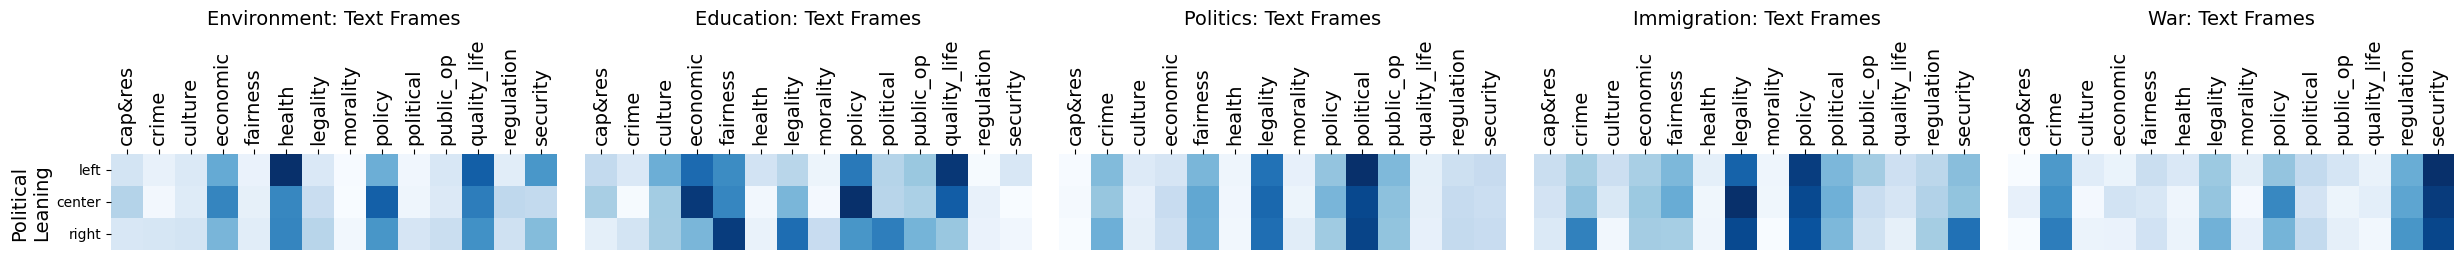

Saved combined image frame distribution for all topics


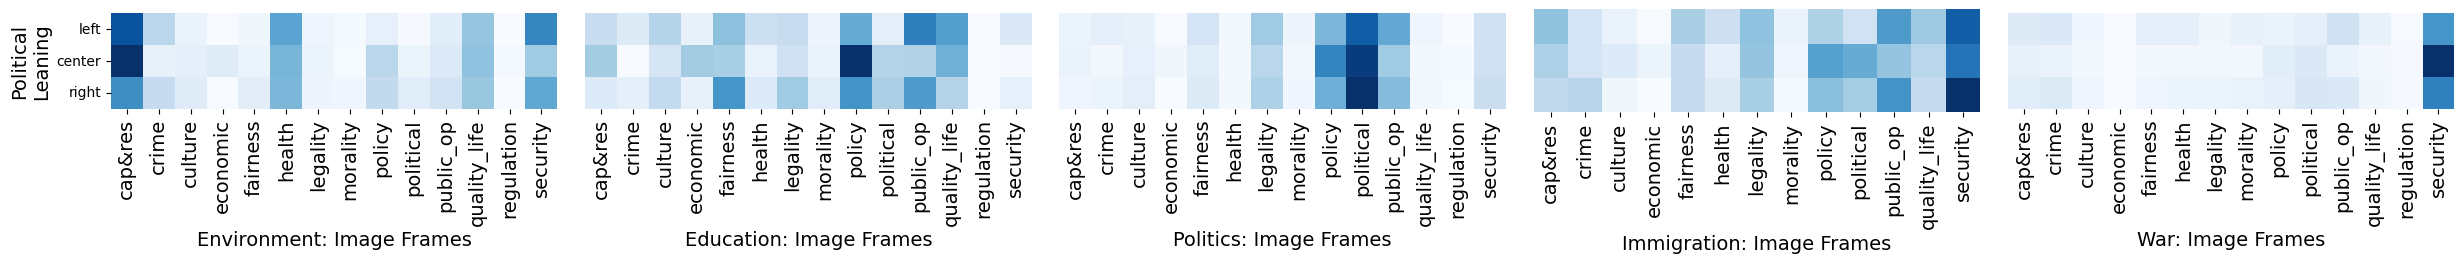

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_text_frames(df, topics, output_plots):
    # Ensure frame columns are lists
    df['short-text-generic-frame'] = df['short-text-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    
    num_topics = len(topics)
    fig_text, axes_text = plt.subplots(nrows=1, ncols=num_topics, figsize=(5 * num_topics, 5))
    
    for idx, topic in enumerate(topics):
        df_topic = df[df['gpt-topic'] == topic]
        
        # Explode frames into separate rows
        text_frame_counts = df_topic.explode('short-text-generic-frame')

        # Aggregate counts for text frames
        text_frame_pivot = text_frame_counts.groupby(['political_leaning', 'short-text-generic-frame']).size().unstack(fill_value=0)

        # Normalize each row by total count for that political leaning
        text_frame_pivot = text_frame_pivot.div(text_frame_pivot.sum(axis=1), axis=0)

        # Reorder political leaning to be in the desired order
        political_order = ["left", "center", "right"]
        text_frame_pivot = text_frame_pivot.reindex(political_order)

        text_frame_pivot.columns.name = None
        # Plot text frames
        sns.heatmap(text_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar=False, ax=axes_text[idx])
        
        # Set a clearer title for the subplot (at the top)
        axes_text[idx].set_title(f"{topic}: Text Frames", fontsize=14, pad=10)
        
        # Move x ticks to the top
        axes_text[idx].tick_params(axis='x', 
                                   labelsize=14, 
                                   rotation=90, 
                                   top=True,      # Turn on ticks at the top
                                   bottom=False,  # Turn off ticks at the bottom
                                   labeltop=True, 
                                   labelbottom=False)

        if idx == 0:
            axes_text[idx].set_ylabel("Political\nLeaning", fontsize=14)
        else:
            axes_text[idx].set_ylabel("")
            axes_text[idx].tick_params(axis='y', left=False, labelleft=False)

    # Adjust layout so y-labels and top labels don't get cut off
    plt.tight_layout(pad=2.0)
    
    # Save and show
    fig_text.savefig(os.path.join(output_plots, 'all_topic_combined_text_frame_distribution.png'), bbox_inches='tight')
    print(f"Saved combined text frame distribution for all topics")
    plt.show()

def plot_image_frames(df, topics, output_plots):
    # Ensure frame columns are lists
    df['img-generic-frame'] = df['img-generic-frame'].apply(lambda x: x if isinstance(x, list) else [])
    
    num_topics = len(topics)
    fig_img, axes_img = plt.subplots(nrows=1, ncols=num_topics, figsize=(5 * num_topics, 5))
    
    for idx, topic in enumerate(topics):
        df_topic = df[df['gpt-topic'] == topic]
        
        # Explode frames into separate rows
        img_frame_counts = df_topic.explode('img-generic-frame')

        # Aggregate counts for image frames
        img_frame_pivot = img_frame_counts.groupby(['political_leaning', 'img-generic-frame']).size().unstack(fill_value=0)

        # Normalize each row by total count for that political leaning
        img_frame_pivot = img_frame_pivot.div(img_frame_pivot.sum(axis=1), axis=0)

        # Reorder political leaning to be in the desired order
        political_order = ["left", "center", "right"]
        img_frame_pivot = img_frame_pivot.reindex(political_order)

        # Plot image frames
        sns.heatmap(img_frame_pivot, cmap='Blues', annot=False, fmt=".2f", square=True, cbar=False, ax=axes_img[idx])
        
        # Instead of set_title, place the "title" as the x-axis label, below the ticks
        axes_img[idx].set_xlabel(f"{topic}: Image Frames", fontsize=14)
        axes_img[idx].tick_params(axis='x', 
                                  labelsize=14, 
                                  rotation=90, 
                                  top=False,    # Keep ticks off top
                                  bottom=True,  # Show ticks at bottom
                                  labeltop=False, 
                                  labelbottom=True)

        if idx == 0:
            axes_img[idx].set_ylabel("Political\nLeaning", fontsize=14)
        else:
            axes_img[idx].set_ylabel("")
            axes_img[idx].tick_params(axis='y', left=False, labelleft=False)

    # Adjust layout so the left labels and bottom x-labels are visible
    plt.tight_layout(pad=2.0)
    
    # Save and show
    fig_img.savefig(os.path.join(output_plots, 'all_topic_combined_image_frame_distribution.png'), bbox_inches='tight')
    print(f"Saved combined image frame distribution for all topics")
    plt.show()

# Define topics
topics_list = ['Environment', 'Education', 'Politics', 'Immigration', 'War']

# Run the functions
plot_text_frames(df, topics_list, output_plots)
plot_image_frames(df, topics_list, output_plots)

### Vizualization 3: Topic Clustering with Political Leaning (TSNE Scatter Plot)
- To understand how news topics cluster based on political leaning and frames.
- TSNE/PCA Scatter Plot: Each point represents an article, colored by political leaning, with clusters showing relationships between frames and topics.

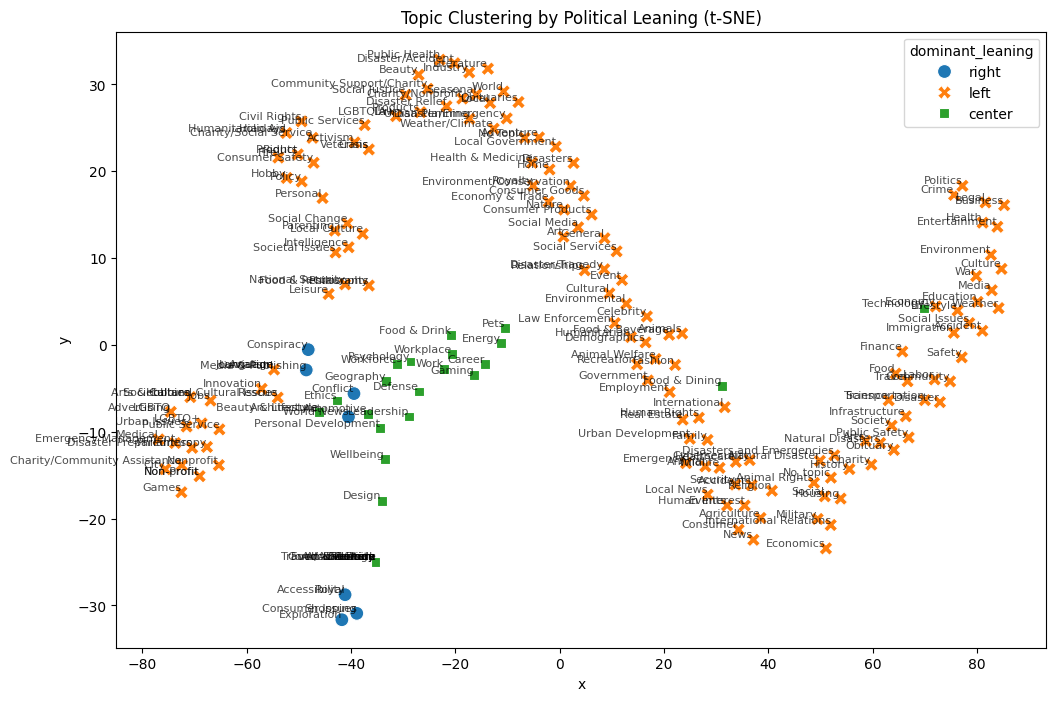

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_topic_clustering(df):
    # 1. Create a pivot: Rows = each topic, Columns = political leaning counts
    topic_counts = df.groupby(['gpt-topic', 'political_leaning']).size().unstack(fill_value=0)

    # 2. Reduce dimensionality using PCA
    pca = PCA(n_components=2, random_state=42)
    topic_embeddings = pca.fit_transform(topic_counts)

    # 3. t-SNE with optimal perplexity for 200 topics
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    tsne_results = tsne.fit_transform(topic_embeddings)

    # 4. Prepare a DataFrame for plotting
    scatter_df = pd.DataFrame(tsne_results, columns=['x', 'y'])
    scatter_df['topic'] = topic_counts.index
    
    # Assign dominant political leaning based on max count
    scatter_df['dominant_leaning'] = topic_counts.idxmax(axis=1).values

    # 5. Determine font size based on topic count (adaptive scaling)
    num_topics = len(scatter_df)
    if num_topics > 150:
        font_size = 8  # Smaller labels for high topic count
    elif num_topics > 100:
        font_size = 5
    elif num_topics > 50:
        font_size = 6
    else:
        font_size = 12  # Larger labels for fewer topics

    # 6. Plot with labels
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        data=scatter_df,
        x='x', y='y',
        hue='dominant_leaning',  # color by dominant leaning
        style='dominant_leaning',
        s=100
    )

    # 7. Add topic labels with adaptive font size
    for _, row in scatter_df.iterrows():
        plt.text(row['x'], row['y'], row['topic'], fontsize=font_size, ha='right', va='bottom', alpha=0.7)

    plt.title("Topic Clustering by Political Leaning (t-SNE)")
    plt.show()

# Example usage (assuming 'df' has 200 topics):
plot_topic_clustering(analysis_annotation_df)


### For paper header: Show random 5 rows where all frames in text and all frames in image are different

In [ ]:
# Show random 5 rows where all frames in text and all frames in image are different. 
sampled_diff_frame = df[(df['short-text-generic-frame'] != df['img-generic-frame'])].sample(5)

#show columns: 'short-text-generic-frame', 'img-generic-frame', 'gpt-topic', 'political_leaning', 'title', 'maintext', 'img_url', 'uuid'
sampled_diff_frame[['short-text-generic-frame', 'img-generic-frame', 'gpt-topic', 'political_leaning', 'title', 'maintext', 'image-url', 'uuid']]

FileNotFoundError: [Errno 2] No such file or directory: '/projects/frame_align/data/filtered/vision/2023-11-01_2023-11-30/c9a3c1f3-9217-46f8-8cd2-291e5153e036.jpg'

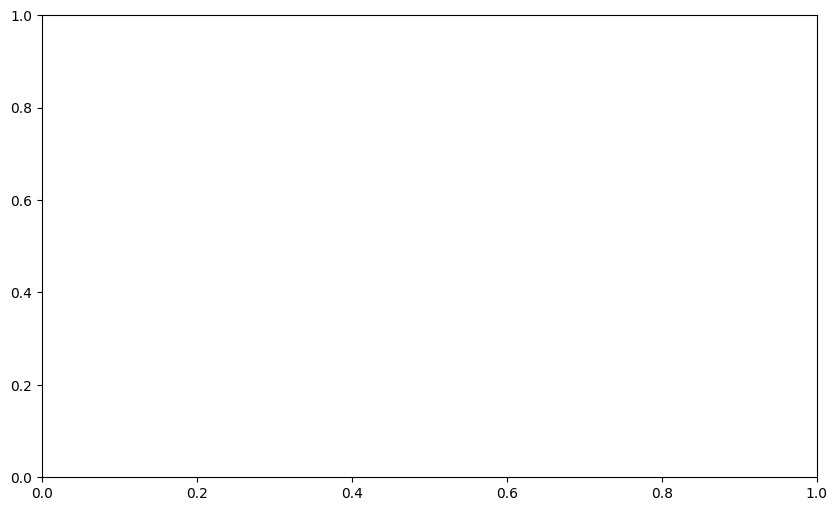

In [51]:
# plot the image from image-url column and write the title and maintext, political leaning, text frames and image frames on the image.

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_text(df):
    # Sample a random row where text and image frames are different
    sampled_row = df[(df['short-text-generic-frame'] != df['img-generic-frame'])].sample(1).iloc[0]
    
    # Extract relevant information
    title = sampled_row['title']
    maintext = sampled_row['maintext']
    political_leaning = sampled_row['political_leaning']
    text_frames = sampled_row['short-text-generic-frame']
    img_frames = sampled_row['img-generic-frame']
    img_url = sampled_row['image-url']
    
    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(plt.imread(img_url))
    
    # Add title and maintext
    ax.set_title(title, fontsize=14)
    ax.text(0.5, 0.95, maintext, ha='center', va='top', fontsize=12, transform=ax.transAxes)
    
    # Add political leaning
    ax.text(0.5, 0.05, f"Political Leaning: {political_leaning}", ha='center', va='bottom', fontsize=12, transform=ax.transAxes)
    
    # Add text frames
    ax.text(0.5, 0.1, "Text Frames: " + ", ".join(text_frames), ha='center', va='bottom', fontsize=12
            , transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Add image frames
    ax.text(0.5, 0.15, "Image Frames: " + ", ".join(img_frames), ha='center', va='bottom', fontsize=12
            , transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Remove axes
    ax.axis('off')
    
    plt.show()
    
# Example usage
plot_image_with_text(df)


In [46]:
df.columns

Index(['text-topic', 'text-topic-exp', 'text-entity-name',
       'text-entity-gender', 'text-entity-sentiment',
       'text-entity-sentiment-exp', 'text-generic-frame',
       'text-generic-frame-exp', 'text-issue-frame', 'text-issue-frame-exp',
       'uuid', 'title', 'img-generic-frame', 'img-frame-exp',
       'img-entity-name', 'img-entity-gender', 'img-entity-sentiment',
       'img-entity-sentiment-exp', 'image-url', 'gpt-topic', 'authors',
       'date_publish', 'description', 'language', 'maintext', 'source_domain',
       'url', 'political_leaning', 'short-text-generic-frame',
       'img-generic-frame-len', 'text-generic-frame-len'],
      dtype='object')